<a href="https://colab.research.google.com/github/Dalia-Sher/Generating-Facial-Expressions-Bidirectional-Conditional-WGAN/blob/Shir/9_BiCoWGAN_with_augmentation_not_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip fer2013.zip

Archive:  fer2013.zip
  inflating: fer2013.csv             


In [2]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, concatenate, Conv2DTranspose, Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.utils import plot_model
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Load Dataset

In [3]:
data = pd.read_csv('fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [5]:
dic = {0:'Angry', 1:'disgust' , 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

The emotion disgust has too few samples, therefore we won't use it

In [6]:
data = data[data.emotion != 1]
data['emotion'] = data.emotion.replace(6, 1)

In [7]:
data.emotion.value_counts()

3    8989
1    6198
4    6077
2    5121
0    4953
5    4002
Name: emotion, dtype: int64

We will redefine the dictionary

In [8]:
dic = {0:'Angry', 1:'Neutral', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise'}

In [9]:
num_classes = 6
img_width = 48
img_height = 48

In [10]:
X = data['pixels']
y = data['emotion']

X_train = []
for i in X:
    X_train.append([int(j) for j in i.split()])

X_train = np.array(X_train)/255.0
X_train = X_train.reshape(X_train.shape[0], img_width, img_height, 1)
X_train = X_train.astype('float32')

print(X_train.shape)

(35340, 48, 48, 1)


(48, 48, 1)


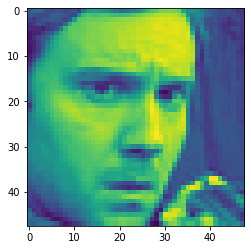

In [11]:
#example of an image from the dataset
print(X_train[0].shape)
plt.imshow(X_train[0].squeeze())

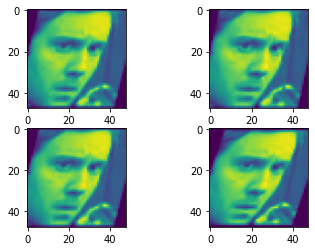

In [13]:
#shear - 4 new images
img = X_train[0]
shear_images = []
for i in range(4):
  shear = iaa.Affine(shear=(0,20))
  shear_img = shear.augment_image(img)
  shear_images.append(shear_img)
  plt.subplot(220 + 1 + i)
  plt.imshow(shear_img.squeeze())
plt.show()

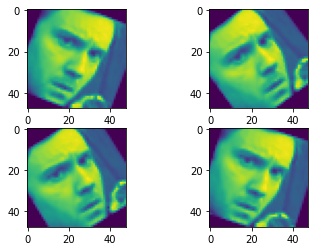

In [14]:
#rotation - 4 new images
img = X_train[0]
rotated_images = []
for i in range(4):
  rotate = iaa.Affine(rotate=(-50+i*5, 30+i*5))
  rotated_img = rotate.augment_image(img)
  rotated_images.append(rotated_img)
  plt.subplot(220 + 1 + i)
  plt.imshow(rotated_img.squeeze())
plt.show()

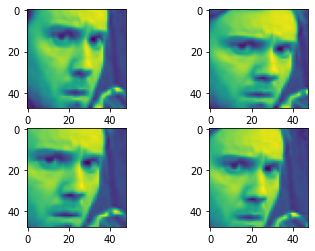

In [15]:
#cropping - 4 new images
img = X_train[0]
cropped_images = []
for i in range(4):
  crop = iaa.Crop(percent=(0, 0.2)) # crop image
  crop_image=crop.augment_image(img)
  cropped_images.append(crop_image)
  plt.subplot(220 + 1 + i)
  plt.imshow(crop_image.squeeze())
plt.show()

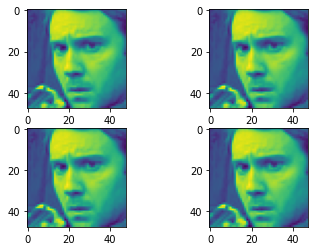

In [16]:
#flipping image horizontally- 4 new images
img = X_train[0]
flipped_images = []
for i in range(4):
  flip_hr = iaa.Fliplr(p=1.0)
  flip_hr_image= flip_hr.augment_image(img)
  flipped_images.append(flip_hr_image)
  plt.subplot(220 + 1 + i)
  plt.imshow(flip_hr_image.squeeze())
plt.show()


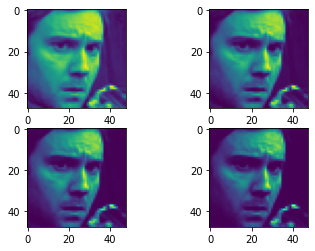

In [17]:
#Changing the brightness of the image
img = X_train[0]
contrasted_images = []
for i in range(4):
  contrast = iaa.GammaContrast(gamma=2.0 + i)
  contrast_image =contrast.augment_image(img)
  contrasted_images.append(contrast_image)
  plt.subplot(220 + 1 + i)
  plt.imshow(contrast_image.squeeze())
plt.show()

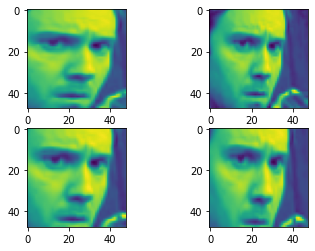

In [18]:
#scaling
img = X_train[0]
scaled_images = []
for i in range(4):
  scale_im = iaa.Affine(scale={"x": (1.5, 1.0), "y": (1.5, 1.0)})
  scale_image =scale_im.augment_image(img)
  scaled_images.append(scale_image)
  plt.subplot(220 + 1 + i)
  plt.imshow(scale_image.squeeze())
plt.show()